In [1]:
import os
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
RANDOM_STATE = 110

train_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/trim_test_data.csv")
test_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/trim_train_data.csv")

In [3]:
# target 열을 임시로 분리
target_train = train_data['target']
target_test = test_data['target']

# 모든 값이 NaN인 열 제거
train_data = train_data.dropna(axis=1, how='all')
test_data = test_data.dropna(axis=1, how='all')

# target 열을 다시 결합
train_data['target'] = target_train
test_data['target'] = target_test

# 제거 후 데이터 확인
print("All columns with only NaN values have been removed, except for the target column.")

All columns with only NaN values have been removed, except for the target column.


In [4]:
wip_line_columns = train_data.filter(like='Wip Line').columns

new_df = train_data.filter(items=wip_line_columns)

new_df.value_counts()

Wip Line_Dam  Wip Line_AutoClave  Wip Line_Fill1  Wip Line_Fill2
IVI-OB6       IVI-OB6             IVI-OB6         IVI-OB6           17361
Name: count, dtype: int64

In [5]:
train_data.drop(columns=wip_line_columns, inplace=True)
test_data.drop(columns=wip_line_columns, inplace=True)

In [6]:
Process_Desc_col = train_data.filter(like='Process Desc').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

Process Desc._Dam  Process Desc._AutoClave  Process Desc._Fill1  Process Desc._Fill2
Dam Dispenser      Auto Clave Out           Fill1 Dispenser      Fill2 Dispenser        17361
Name: count, dtype: int64

In [7]:
train_data = train_data.drop(columns=['Process Desc._Dam', 'Process Desc._AutoClave', 'Process Desc._Fill1', 'Process Desc._Fill2'])
test_data = test_data.drop(columns=['Process Desc._Dam', 'Process Desc._AutoClave', 'Process Desc._Fill1', 'Process Desc._Fill2'])

In [8]:
# Equipment로 시작하는 열 필터링
Equipment_col = train_data.filter(like='Equipment').columns
new3_df = train_data.filter(items=Equipment_col)

# target 변수 추가
new3_df['target'] = train_data['target']

# 그룹별로 target 변수의 비율 계산
target_ratio = new3_df.groupby(list(Equipment_col))['target'].value_counts(normalize=True).unstack().fillna(0)

# AbNormal 비율 출력
abnormal_ratio = target_ratio.get('AbNormal', 0)
print("각 그룹의 abnormal_ratio:")
print(abnormal_ratio)

# 각 그룹에 값의 갯수 출력
group_counts = new3_df.groupby(list(Equipment_col)).size()
print("각 그룹의 값의 갯수:")
print(group_counts)

각 그룹의 abnormal_ratio:
0
각 그룹의 값의 갯수:
Equipment_Dam     Equipment_AutoClave  Equipment_Fill1     Equipment_Fill2   
Dam dispenser #1  Auto Clave Out       Fill1 dispenser #1  Fill2 dispenser #1    10731
                                                           Fill2 dispenser #2        2
                                       Fill1 dispenser #2  Fill2 dispenser #2        1
Dam dispenser #2  Auto Clave Out       Fill1 dispenser #1  Fill2 dispenser #1        5
                                       Fill1 dispenser #2  Fill2 dispenser #1        4
                                                           Fill2 dispenser #2     6618
dtype: int64


In [9]:
# Equipment로 시작하는 열 필터링
Equipment_col = train_data.filter(like='Equipment').columns
Equipment_col2 = test_data.filter(like='Equipment').columns

new3_df = train_data.filter(items=Equipment_col)
new3_df2 = test_data.filter(items=Equipment_col2)

# Equipment_same_num 파생변수 생성
def determine_equipment_same_num(row):
    if (row['Equipment_Dam'] == 'Dam dispenser #1' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
        row['Equipment_Fill1'] == 'Fill1 dispenser #1' and row['Equipment_Fill2'] == 'Fill2 dispenser #1') or \
       (row['Equipment_Dam'] == 'Dam dispenser #2' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
        row['Equipment_Fill1'] == 'Fill1 dispenser #2' and row['Equipment_Fill2'] == 'Fill2 dispenser #2'):
        return 1
    else:
        return 0

train_data['Equipment_same_num'] = new3_df.apply(determine_equipment_same_num, axis=1)
test_data['Equipment_same_num'] = new3_df2.apply(determine_equipment_same_num, axis=1)

train_data = train_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])
test_data = test_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])

In [10]:
Process_Desc_col = train_data.filter(like='Model.Suffix').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

Model.Suffix_Dam  Model.Suffix_AutoClave  Model.Suffix_Fill1  Model.Suffix_Fill2
AJX75334501       AJX75334501             AJX75334501         AJX75334501           14495
AJX75334502       AJX75334502             AJX75334502         AJX75334502            1405
AJX75334505       AJX75334505             AJX75334505         AJX75334505            1189
AJX75334507       AJX75334507             AJX75334507         AJX75334507             137
AJX75334503       AJX75334503             AJX75334503         AJX75334503              66
AJX75334506       AJX75334506             AJX75334506         AJX75334506              41
AJX75334508       AJX75334508             AJX75334508         AJX75334508              28
Name: count, dtype: int64

In [11]:
# Model.Suffix_Dam의 이름을 Model.Suffix로 변경
train_data = train_data.rename(columns={'Model.Suffix_Dam': 'Model.Suffix'})
test_data = test_data.rename(columns={'Model.Suffix_Dam': 'Model.Suffix'})

# Model.Suffix_AutoClave, Model.Suffix_Fill1, Model.Suffix_Fill2 열 드롭
train_data = train_data.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])
test_data = test_data.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])

In [12]:
# Workorder로 시작하는 열 필터링
workorder_cols = ['Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2']

# Workorder 열들로 이루어진 데이터프레임 생성
workorder_df = train_data[workorder_cols]

# 4개의 변수의 값이 모두 동일하지 않은 행 필터링
different_workorders = workorder_df[
    (workorder_df['Workorder_Dam'] != workorder_df['Workorder_AutoClave']) |
    (workorder_df['Workorder_Dam'] != workorder_df['Workorder_Fill1']) |
    (workorder_df['Workorder_Dam'] != workorder_df['Workorder_Fill2']) |
    (workorder_df['Workorder_AutoClave'] != workorder_df['Workorder_Fill1']) |
    (workorder_df['Workorder_AutoClave'] != workorder_df['Workorder_Fill2']) |
    (workorder_df['Workorder_Fill1'] != workorder_df['Workorder_Fill2'])
]

# 결과 출력
print("4개의 변수의 값이 모두 동일하지 않은 경우:")
print(different_workorders)

4개의 변수의 값이 모두 동일하지 않은 경우:
Empty DataFrame
Columns: [Workorder_Dam, Workorder_AutoClave, Workorder_Fill1, Workorder_Fill2]
Index: []


In [13]:
# Model.workorder_Dam의 이름을 Model.Suffix로 변경
train_data = train_data.rename(columns={'Workorder_Dam': 'Workorder'})
test_data = test_data.rename(columns={'Workorder_Dam': 'Workorder'})

# Model.Suffix_AutoClave, Model.Suffix_Fill1, Model.Suffix_Fill2 열 드롭
train_data = train_data.drop(columns=['Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])
test_data = test_data.drop(columns=['Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])

In [14]:
Process_Desc_col = train_data.filter(like='Insp. Seq No.').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

Insp. Seq No._Dam  Insp. Seq No._AutoClave  Insp. Seq No._Fill1  Insp. Seq No._Fill2
1                  1                        1                    1                      17361
Name: count, dtype: int64

In [15]:
train_data = train_data.drop(columns=['Insp. Seq No._Dam', 'Insp. Seq No._AutoClave', 'Insp. Seq No._Fill1', 'Insp. Seq No._Fill2'])
test_data = test_data.drop(columns=['Insp. Seq No._Dam', 'Insp. Seq No._AutoClave', 'Insp. Seq No._Fill1', 'Insp. Seq No._Fill2'])

In [16]:
Process_Desc_col = train_data.filter(like='Insp Judge Code').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

train_data = train_data.drop(columns=['Insp Judge Code_Dam', 'Insp Judge Code_AutoClave', 'Insp Judge Code_Fill1', 'Insp Judge Code_Fill2'])
test_data = test_data.drop(columns=['Insp Judge Code_Dam', 'Insp Judge Code_AutoClave', 'Insp Judge Code_Fill1', 'Insp Judge Code_Fill2'])

In [17]:
# 값의 종류가 1개이고 결측값이 없는 열을 제거하는 함수
def drop_single_value_columns(df):
    cols_to_drop = [col for col in df.columns if col != 'target' and df[col].nunique() == 1 and df[col].isnull().sum() == 0]
    df_dropped = df.drop(columns=cols_to_drop)
    return df_dropped, cols_to_drop

# train_data와 test_data에서 해당 열 제거 및 삭제된 열 이름과 개수 출력
train_data, train_cols_dropped = drop_single_value_columns(train_data)
test_data, test_cols_dropped = drop_single_value_columns(test_data)

# print("삭제된 train_data 열 이름:", train_cols_dropped)
print("삭제된 train_data 열 개수:", len(train_cols_dropped))

# print("삭제된 test_data 열 이름:", test_cols_dropped)
print("삭제된 test_data 열 개수:", len(test_cols_dropped))

삭제된 train_data 열 개수: 42
삭제된 test_data 열 개수: 42


In [18]:
train_data.info()
print('---')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Columns: 120 entries, Set ID to Equipment_same_num
dtypes: float64(94), int64(17), object(9)
memory usage: 15.9+ MB
---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 119 entries, Model.Suffix to Equipment_same_num
dtypes: float64(58), int64(52), object(9)
memory usage: 36.8+ MB


# Fill1  

Machine Tact time을 범주화하여 각 계급별 normal, abnormal 개수 및 비율을 분석

In [117]:
train_data=pd.read_csv('C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/train_data.csv')

In [118]:
train_data['Machine Tact time Collect Result_Fill1'].value_counts()

Machine Tact time Collect Result_Fill1
91.4     1971
57.4     1652
57.5     1261
91.3     1135
57.8     1093
         ... 
203.8       1
85.2        1
81.3        1
45.3        1
97.7        1
Name: count, Length: 355, dtype: int64

In [119]:
# Create a new variable with only the first 5 characters of the Workorder unique values
train_data['Workorder_Prefix'] = train_data['Workorder'].str[:5]
# Create a new variable with only the first 5 characters of the Workorder unique values
test_data['Workorder_Prefix'] = test_data['Workorder'].str[:5]

In [120]:
# Group by 'Model.Suffix' and calculate the average value of 'Machine Tact time Collect Result_Fill1'
average_machine_tact_time = train_data.groupby('Model.Suffix')['Machine Tact time Collect Result_Fill1'].mean()

average_machine_tact_time

Model.Suffix
AJX75334501    67.137954
AJX75334502    59.163009
AJX75334503    64.679630
AJX75334505    58.186224
AJX75334506    67.939535
AJX75334507    57.819032
AJX75334508    56.170000
Name: Machine Tact time Collect Result_Fill1, dtype: float64

In [121]:
# Find the minimum and maximum values of 'Machine Tact time Collect Result_Fill1'
min_machine_tact_time = train_data['Machine Tact time Collect Result_Fill1'].min()
max_machine_tact_time = train_data['Machine Tact time Collect Result_Fill1'].max()

print(min_machine_tact_time, max_machine_tact_time)

0.0 214.9


각 Mahcine tact time 별로 불량품 비율이 다른 것을 알 수 있었다.

In [122]:
# Divide the machine tact time into 10 classes
time_bins = pd.cut(train_data['Machine Tact time Collect Result_Fill1'], bins=10)

# Group by the time bins and target to find the count of abnormal and normal for each class
class_counts = train_data.groupby([time_bins, 'target']).size().unstack(fill_value=0)

# Calculate the abnormal composition ratio for each class
class_counts['Abnormal Composition Ratio'] = class_counts['AbNormal'] / (class_counts['AbNormal'] + class_counts['Normal'])

# Fill NaN values with 0 (in cases where both AbNormal and Normal counts are 0)

class_counts

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_3148\276577042.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  class_counts = train_data.groupby([time_bins, 'target']).size().unstack(fill_value=0)


target,AbNormal,Normal,Abnormal Composition Ratio
Machine Tact time Collect Result_Fill1,,,
"(-0.215, 21.49]",1,0,1.000000
"(21.49, 42.98]",1,7,0.125000
"(42.98, 64.47]",1362,25419,0.050857
"(64.47, 85.96]",211,4377,0.045990
"(85.96, 107.45]",761,8248,0.084471
"(107.45, 128.94]",12,97,0.110092
"(128.94, 150.43]",1,3,0.250000
"(150.43, 171.92]",0,1,0.000000
"(171.92, 193.41]",1,2,0.333333


42.98~120 구간에 데이터가 몰려있어서 이 부분만 따로 떼어서 확인해보았다.

In [124]:
filtered_data = train_data[train_data['Machine Tact time Collect Result_Fill1'].between(42.98,120)]

# Divide the machine tact time into 10 classes
time_bins = pd.cut(filtered_data['Machine Tact time Collect Result_Fill1'], bins=10)

# Group by the time bins and target to find the count of abnormal and normal for each class
class_counts = filtered_data.groupby([time_bins, 'target']).size().unstack(fill_value=0)

# Calculate the abnormal composition ratio for each class
class_counts['Abnormal Composition Ratio'] = class_counts['AbNormal'] / (class_counts['AbNormal'] + class_counts['Normal'])

# Fill NaN values with 0 (in cases where both AbNormal and Normal counts are 0)

class_counts

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_3148\2311933336.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  class_counts = filtered_data.groupby([time_bins, 'target']).size().unstack(fill_value=0)


target,AbNormal,Normal,Abnormal Composition Ratio
Machine Tact time Collect Result_Fill1,,,
"(44.127, 51.5]",46,851,0.051282
"(51.5, 58.8]",1195,23369,0.048648
"(58.8, 66.1]",125,1232,0.092115
"(66.1, 73.4]",142,3128,0.043425
"(73.4, 80.7]",48,1155,0.039900
"(80.7, 88.0]",18,70,0.204545
"(88.0, 95.3]",760,8221,0.084623
"(95.3, 102.6]",0,18,0.000000
"(102.6, 109.9]",0,0,NaN


In [125]:
filtered_data2 = train_data[train_data['Machine Tact time Collect Result_Fill1'].between(51,59)]

# Divide the machine tact time into 10 classes
time_bins = pd.cut(filtered_data2['Machine Tact time Collect Result_Fill1'], bins=10)

# Group by the time bins and target to find the count of abnormal and normal for each class
class_counts = filtered_data2.groupby([time_bins, 'target']).size().unstack(fill_value=0)

# Calculate the abnormal composition ratio for each class
class_counts['Abnormal Composition Ratio'] = class_counts['AbNormal'] / (class_counts['AbNormal'] + class_counts['Normal'])

# Fill NaN values with 0 (in cases where both AbNormal and Normal counts are 0)

class_counts

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_3148\1287287821.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  class_counts = filtered_data2.groupby([time_bins, 'target']).size().unstack(fill_value=0)


target,AbNormal,Normal,Abnormal Composition Ratio
Machine Tact time Collect Result_Fill1,,,
"(50.992, 51.8]",37,650,0.053857
"(51.8, 52.6]",42,725,0.054759
"(52.6, 53.4]",61,1430,0.040912
"(53.4, 54.2]",81,1460,0.052563
"(54.2, 55.0]",174,3552,0.046699
"(55.0, 55.8]",62,1005,0.058107
"(55.8, 56.6]",218,4039,0.051210
"(56.6, 57.4]",172,4006,0.041168
"(57.4, 58.2]",287,5139,0.052893


In [126]:
filtered_data3 = train_data[train_data['Machine Tact time Collect Result_Fill1'].between(59,66)]

# Divide the machine tact time into 10 classes
time_bins = pd.cut(filtered_data3['Machine Tact time Collect Result_Fill1'], bins=10)

# Group by the time bins and target to find the count of abnormal and normal for each class
class_counts = filtered_data3.groupby([time_bins, 'target']).size().unstack(fill_value=0)

# Calculate the abnormal composition ratio for each class
class_counts['Abnormal Composition Ratio'] = class_counts['AbNormal'] / (class_counts['AbNormal'] + class_counts['Normal'])

# Fill NaN values with 0 (in cases where both AbNormal and Normal counts are 0)

class_counts

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_3148\2374610552.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  class_counts = filtered_data3.groupby([time_bins, 'target']).size().unstack(fill_value=0)


target,AbNormal,Normal,Abnormal Composition Ratio
Machine Tact time Collect Result_Fill1,,,
"(58.993, 59.69]",19,246,0.071698
"(59.69, 60.38]",12,85,0.123711
"(60.38, 61.07]",6,60,0.090909
"(61.07, 61.76]",49,465,0.095331
"(61.76, 62.45]",6,56,0.096774
"(62.45, 63.14]",2,7,0.222222
"(63.14, 63.83]",11,134,0.075862
"(63.83, 64.52]",7,73,0.087500
"(64.52, 65.21]",2,13,0.133333


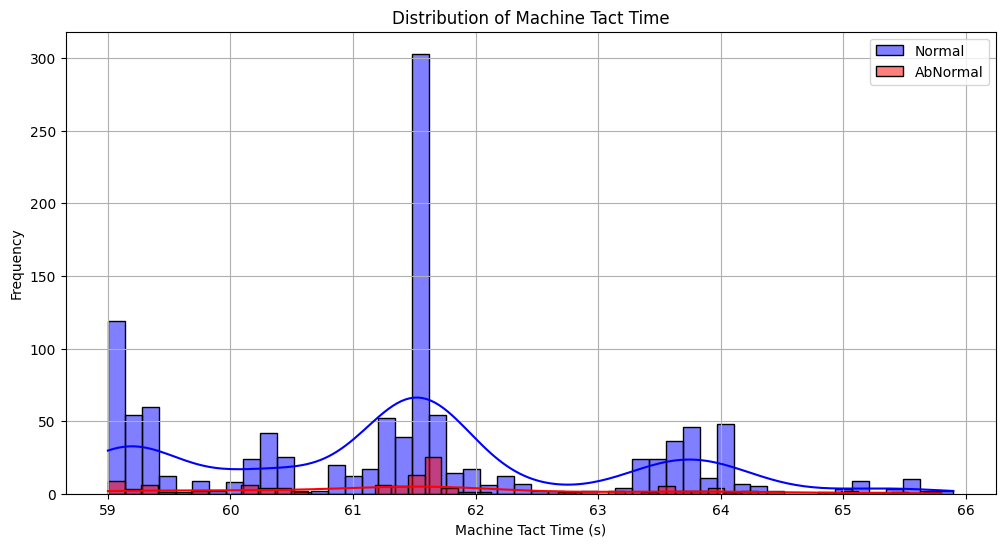

In [128]:
# Filter the data for abnormal and normal
abnormal_data = filtered_data3[filtered_data3['target'] == 'AbNormal']
normal_data = filtered_data3[filtered_data3['target'] == 'Normal']

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.histplot(normal_data['Machine Tact time Collect Result_Fill1'], bins=50, kde=True, color='blue', label='Normal')
sns.histplot(abnormal_data['Machine Tact time Collect Result_Fill1'], bins=50, kde=True, color='red', label='AbNormal')

plt.title('Distribution of Machine Tact Time')
plt.xlabel('Machine Tact Time (s)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [130]:
# Define the tact time ranges
tact_time_ranges = [(58.993, 60),(60, 62),(62, 64),(64,66)]

# Initialize an empty dictionary to store the results
model_suffix_counts_by_range = {}

# Iterate over the defined tact time ranges
for start, end in tact_time_ranges:
    # Filter the data for the specified tact time range
    filtered_data = train_data[train_data['Machine Tact time Collect Result_Fill1'].between(start, end)]
    
    # Get the unique model suffixes
    model_suffixes = filtered_data['Workorder_Prefix'].unique()
    
    # Initialize a dictionary to store counts for each model suffix
    model_suffix_counts = {}
    
    # Iterate over the unique model suffixes
    for model_suffix in model_suffixes:
        # Filter data for the current model suffix
        model_data = filtered_data[filtered_data['Workorder_Prefix'] == model_suffix]
        
        # Count the number of normal and abnormal rows
        normal_count = model_data[model_data['target'] == 'Normal'].shape[0]
        abnormal_count = model_data[model_data['target'] == 'AbNormal'].shape[0]
        
        # Store the counts in the dictionary
        model_suffix_counts[model_suffix] = {'Normal': normal_count, 'AbNormal': abnormal_count}
    
    # Store the result in the main dictionary
    model_suffix_counts_by_range[(start, end)] = model_suffix_counts

# Display the results
model_suffix_counts_by_range

{(58.993, 60): {'3M1XG': {'Normal': 55, 'AbNormal': 2},
  '3M1XH': {'Normal': 68, 'AbNormal': 5},
  '4F1XA': {'Normal': 11, 'AbNormal': 0},
  '3L1XA': {'Normal': 20, 'AbNormal': 3},
  '4F1X6': {'Normal': 4, 'AbNormal': 0},
  '4E1XA': {'Normal': 52, 'AbNormal': 2},
  '3M1XB': {'Normal': 4, 'AbNormal': 2},
  '4C1XD': {'Normal': 1, 'AbNormal': 0},
  '3L1XB': {'Normal': 17, 'AbNormal': 3},
  '4E1X9': {'Normal': 15, 'AbNormal': 1},
  '4C1XH': {'Normal': 3, 'AbNormal': 0},
  '3M1XC': {'Normal': 0, 'AbNormal': 3},
  '3M1XF': {'Normal': 2, 'AbNormal': 0},
  '3J1XE': {'Normal': 1, 'AbNormal': 0},
  '4C1XJ': {'Normal': 1, 'AbNormal': 0},
  '4F1X9': {'Normal': 1, 'AbNormal': 0},
  '3L1X1': {'Normal': 1, 'AbNormal': 0},
  '4B1XC': {'Normal': 1, 'AbNormal': 0}},
 (60, 62): {'4E1X9': {'Normal': 89, 'AbNormal': 8},
  '4C1XH': {'Normal': 207, 'AbNormal': 13},
  '4C1XJ': {'Normal': 133, 'AbNormal': 9},
  '4C1XG': {'Normal': 32, 'AbNormal': 3},
  '4E1XA': {'Normal': 131, 'AbNormal': 26},
  '4CPXX': {'No

Fill1 Tact time 구간을 확인해본 결과 60~65에서 불량품 확률이 높은 것을 알 수 있었다.
또한 workorder에 따라 불량품 확률이 상이했다. -> workorder와 tact time을 범주화하여 묶어주는 방법을 고려해봐도 좋을 듯?

In [133]:
filtered_data4 = train_data[train_data['Machine Tact time Collect Result_Fill1'].between(109,112)]

# Divide the machine tact time into 10 classes
time_bins = pd.cut(filtered_data4['Machine Tact time Collect Result_Fill1'], bins=10)

# Group by the time bins and target to find the count of abnormal and normal for each class
class_counts = filtered_data4.groupby([time_bins, 'target']).size().unstack(fill_value=0)

# Calculate the abnormal composition ratio for each class
class_counts['Abnormal Composition Ratio'] = class_counts['AbNormal'] / (class_counts['AbNormal'] + class_counts['Normal'])

# Fill NaN values with 0 (in cases where both AbNormal and Normal counts are 0)

class_counts

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_3148\2708587797.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  class_counts = filtered_data4.groupby([time_bins, 'target']).size().unstack(fill_value=0)


target,AbNormal,Normal,Abnormal Composition Ratio
Machine Tact time Collect Result_Fill1,,,
"(110.799, 110.86]",2,14,0.125000
"(110.86, 110.92]",3,37,0.075000
"(110.92, 110.98]",0,0,NaN
"(110.98, 111.04]",5,40,0.111111
"(111.04, 111.1]",1,5,0.166667
"(111.1, 111.16]",0,0,NaN
"(111.16, 111.22]",0,0,NaN
"(111.22, 111.28]",0,0,NaN
"(111.28, 111.34]",0,0,NaN


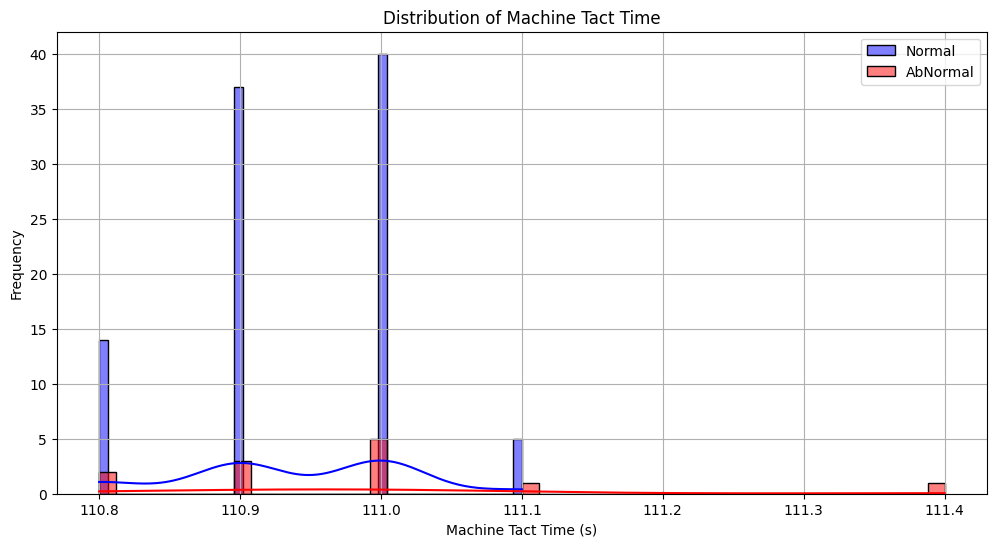

In [134]:
# Filter the data for abnormal and normal
abnormal_data = filtered_data4[filtered_data4['target'] == 'AbNormal']
normal_data = filtered_data4[filtered_data4['target'] == 'Normal']

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.histplot(normal_data['Machine Tact time Collect Result_Fill1'], bins=50, kde=True, color='blue', label='Normal')
sns.histplot(abnormal_data['Machine Tact time Collect Result_Fill1'], bins=50, kde=True, color='red', label='AbNormal')

plt.title('Distribution of Machine Tact Time')
plt.xlabel('Machine Tact Time (s)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [135]:
# Define the tact time ranges
tact_time_ranges = [(110,111),(111,112)]

# Initialize an empty dictionary to store the results
model_suffix_counts_by_range = {}

# Iterate over the defined tact time ranges
for start, end in tact_time_ranges:
    # Filter the data for the specified tact time range
    filtered_data = train_data[train_data['Machine Tact time Collect Result_Fill1'].between(start, end)]
    
    # Get the unique model suffixes
    model_suffixes = filtered_data['Workorder_Prefix'].unique()
    
    # Initialize a dictionary to store counts for each model suffix
    model_suffix_counts = {}
    
    # Iterate over the unique model suffixes
    for model_suffix in model_suffixes:
        # Filter data for the current model suffix
        model_data = filtered_data[filtered_data['Workorder_Prefix'] == model_suffix]
        
        # Count the number of normal and abnormal rows
        normal_count = model_data[model_data['target'] == 'Normal'].shape[0]
        abnormal_count = model_data[model_data['target'] == 'AbNormal'].shape[0]
        
        # Store the counts in the dictionary
        model_suffix_counts[model_suffix] = {'Normal': normal_count, 'AbNormal': abnormal_count}
    
    # Store the result in the main dictionary
    model_suffix_counts_by_range[(start, end)] = model_suffix_counts

# Display the results
model_suffix_counts_by_range

{(110, 111): {'3F1X5': {'Normal': 89, 'AbNormal': 10},
  '3F1X9': {'Normal': 2, 'AbNormal': 0}},
 (111, 112): {'3F1X5': {'Normal': 44, 'AbNormal': 6},
  '3F1X9': {'Normal': 1, 'AbNormal': 0},
  '3K1XC': {'Normal': 0, 'AbNormal': 1}}}

전체 평균 불량률보다 높은 불량률을 가지고 있는 Machine Tact time 구간

In [86]:
# Define the tact time ranges
tact_time_ranges = [(35.817, 42.98),(78.797, 85.96),(85.96, 93.123),(107.45, 114.613)]

# Initialize an empty dictionary to store the results
model_suffix_counts_by_range = {}

# Iterate over the defined tact time ranges
for start, end in tact_time_ranges:
    # Filter the data for the specified tact time range
    filtered_data = train_data[train_data['Machine Tact time Collect Result_Fill1'].between(start, end)]
    
    # Get the unique model suffixes
    model_suffixes = filtered_data['Model.Suffix'].unique()
    
    # Initialize a dictionary to store counts for each model suffix
    model_suffix_counts = {}
    
    # Iterate over the unique model suffixes
    for model_suffix in model_suffixes:
        # Filter data for the current model suffix
        model_data = filtered_data[filtered_data['Model.Suffix'] == model_suffix]
        
        # Count the number of normal and abnormal rows
        normal_count = model_data[model_data['target'] == 'Normal'].shape[0]
        abnormal_count = model_data[model_data['target'] == 'AbNormal'].shape[0]
        
        # Store the counts in the dictionary
        model_suffix_counts[model_suffix] = {'Normal': normal_count, 'AbNormal': abnormal_count}
    
    # Store the result in the main dictionary
    model_suffix_counts_by_range[(start, end)] = model_suffix_counts

# Display the results
model_suffix_counts_by_range

{(35.817, 42.98): {'AJX75334501': {'Normal': 7, 'AbNormal': 1}},
 (78.797, 85.96): {'AJX75334501': {'Normal': 58, 'AbNormal': 18},
  'AJX75334503': {'Normal': 1, 'AbNormal': 0},
  'AJX75334502': {'Normal': 3, 'AbNormal': 0},
  'AJX75334505': {'Normal': 1, 'AbNormal': 0}},
 (85.96, 93.123): {'AJX75334501': {'Normal': 8084, 'AbNormal': 742},
  'AJX75334502': {'Normal': 137, 'AbNormal': 19},
  'AJX75334503': {'Normal': 7, 'AbNormal': 0}},
 (107.45, 114.613): {'AJX75334501': {'Normal': 96, 'AbNormal': 12}}}

구간 별 Machine Tact time을 model.suffix를 기준으로 더 나눠서 normal, abnormal 개수를 확인해본 결과 model.suffix 마다 차이가 존재했다.

In [70]:
# Extracting rows from train_data where the machine tact time is between (21.49, 42.98)
extracted_data = train_data[train_data['Machine Tact time Collect Result_Fill1'].between(21.49, 42.98)]

# Split the extracted data into normal and abnormal based on the target column
normal_data = extracted_data[extracted_data['target'] == 'Normal']
abnormal_data = extracted_data[extracted_data['target'] == 'AbNormal']

In [73]:
normal_data_avg = normal_data.select_dtypes(include=[float, int]).mean()
abnormal_data_avg = abnormal_data.select_dtypes(include=[float, int]).mean()

normal_data_avg_transposed = normal_data_avg.to_frame("Normal Average").transpose()
abnormal_data_avg_transposed = abnormal_data_avg.to_frame("Abnormal Average").transpose()

combined_avg_transposed = pd.concat([normal_data_avg_transposed, abnormal_data_avg_transposed])

combined_avg_transposed

,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION ? Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION ? Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,...,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,Equipment_same_num
Normal Average,348.571429,3.928571,-64.285714,70.0,922.857143,-64.285714,16.0,13.2,6.585714,13.185714,...,243.671429,243.671429,243.671429,85.0,21.171429,4.428571,201.571429,1.0,NaN,1.0
Abnormal Average,240.000000,2.500000,-90.000000,70.0,1030.000000,-90.000000,10.0,9.7,4.900000,9.700000,...,243.700000,243.700000,243.700000,85.0,19.300000,5.000000,29.000000,1.0,0.0,1.0


In [74]:
# Define the tact time ranges to process
tact_time_ranges = [(85.96, 107.45), (107.45, 128.94), (128.94, 150.43), (171.92, 193.41)]

# Initialize an empty dictionary to store the results
average_values_by_range = {}

# Process each tact time range
for tact_time_range in tact_time_ranges:
    # Extract the data for the current tact time range
    extracted_data = train_data[train_data['Machine Tact time Collect Result_Fill1'].between(*tact_time_range)]
    
    # Split the data into normal and abnormal
    normal_data = extracted_data[extracted_data['target'] == 'Normal']
    abnormal_data = extracted_data[extracted_data['target'] == 'AbNormal']
    
    # Calculate the average values for each numerical column
    normal_data_avg = normal_data.select_dtypes(include=[float, int]).mean()
    abnormal_data_avg = abnormal_data.select_dtypes(include=[float, int]).mean()
    
    # Transpose the averages for easier comparison
    normal_data_avg_transposed = normal_data_avg.to_frame("Normal Average").transpose()
    abnormal_data_avg_transposed = abnormal_data_avg.to_frame("Abnormal Average").transpose()
    
    # Combine the transposed averages into a single DataFrame for the current tact time range
    combined_avg_transposed = pd.concat([normal_data_avg_transposed, abnormal_data_avg_transposed])
    
    # Store the result in the dictionary
    average_values_by_range[tact_time_range] = combined_avg_transposed


average_values_by_range

{(85.96,
  107.45):                   CURE END POSITION X Collect Result_Dam  \
 Normal Average                                242.580019   
 Abnormal Average                              240.998686   
 
                   CURE END POSITION Z Collect Result_Dam  \
 Normal Average                                  2.533948   
 Abnormal Average                                2.513141   
 
                   CURE END POSITION ? Collect Result_Dam  \
 Normal Average                                -89.388943   
 Abnormal Average                              -89.763469   
 
                   CURE SPEED Collect Result_Dam  \
 Normal Average                             70.0   
 Abnormal Average                           70.0   
 
                   CURE START POSITION X Collect Result_Dam  \
 Normal Average                                 1027.453928   
 Abnormal Average                               1029.014455   
 
                   CURE START POSITION ? Collect Result_Dam  \
 Normal Averag

Machine Tact time 구간 별 Dispense Volume 분포확인

In [49]:
import scipy.stats as stats

In [59]:
train_data.columns

Index(['Model.Suffix', 'Workorder', 'CURE END POSITION X Collect Result_Dam',
       'CURE END POSITION Z Collect Result_Dam',
       'CURE END POSITION ? Collect Result_Dam',
       'CURE SPEED Collect Result_Dam',
       'CURE START POSITION X Collect Result_Dam',
       'CURE START POSITION ? Collect Result_Dam',
       'DISCHARGED SPEED OF RESIN Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       ...
       'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
       'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
       'Head Purge Position Z Collect Result_Fill2',
       'Machine Tact time Collect Result_Fill2',
       'PalletID Collect Result_Fill2', 'Production Qty Collect Result_Fill2',
       'Receip No Collect Result_Fill2', 'WorkMode Collect Result_Fill2',
       'target', 'Equipment_same_num'],
      dtype='object', length=119)

In [88]:
# Assuming the column names for Fill2 and Dam are similar to Fill1
train_data['Total Machine Tact Time'] = (
    train_data['Machine Tact time Collect Result_Fill1'] + 
    train_data['Machine Tact time Collect Result_Fill2'] + 
    train_data['Machine Tact time Collect Result_Dam']
)

Machine tact time Dam을 확인해보았다.

In [94]:
# Divide the machine tact time into 10 classes
time_bins = pd.cut(train_data['Machine Tact time Collect Result_Dam'], bins=10)

# Group by the time bins and target to find the count of abnormal and normal for each class
class_counts = train_data.groupby([time_bins, 'target']).size().unstack(fill_value=0)

# Calculate the abnormal composition ratio for each class
class_counts['Abnormal Composition Ratio'] = class_counts['AbNormal'] / (class_counts['AbNormal'] + class_counts['Normal'])

# Fill NaN values with 0 (in cases where both AbNormal and Normal counts are 0)

class_counts

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_3148\3863420094.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  class_counts = train_data.groupby([time_bins, 'target']).size().unstack(fill_value=0)


target,AbNormal,Normal,Abnormal Composition Ratio
Machine Tact time Collect Result_Dam,,,
"(34.536, 131.94]",2344,38135,0.057907
"(131.94, 228.38]",3,15,0.166667
"(228.38, 324.82]",2,4,0.333333
"(324.82, 421.26]",0,1,0.000000
"(421.26, 517.7]",0,0,NaN
"(517.7, 614.14]",0,1,0.000000
"(614.14, 710.58]",0,0,NaN
"(710.58, 807.02]",0,0,NaN
"(807.02, 903.46]",0,0,NaN


(34.536, 131.94)이 사이에 몰려있었기 때문에 이 구간을 세분화해서 보기로 했다.

In [107]:
filtered_data = train_data[train_data['Machine Tact time Collect Result_Dam'].between(34.536, 131.94)]

In [108]:
# Divide the machine tact time into 10 classes
time_bins = pd.cut(filtered_data['Machine Tact time Collect Result_Dam'], bins=13)

# Group by the time bins and target to find the count of abnormal and normal for each class
class_counts = filtered_data.groupby([time_bins, 'target']).size().unstack(fill_value=0)

# Calculate the abnormal composition ratio for each class
class_counts['Abnormal Composition Ratio'] = class_counts['AbNormal'] / (class_counts['AbNormal'] + class_counts['Normal'])

# Fill NaN values with 0 (in cases where both AbNormal and Normal counts are 0)

class_counts

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_3148\751619331.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  class_counts = filtered_data.groupby([time_bins, 'target']).size().unstack(fill_value=0)


target,AbNormal,Normal,Abnormal Composition Ratio
Machine Tact time Collect Result_Dam,,,
"(35.408, 42.538]",0,3,0.000000
"(42.538, 49.577]",2,49,0.039216
"(49.577, 56.615]",368,7538,0.046547
"(56.615, 63.654]",655,10880,0.056784
"(63.654, 70.692]",112,2513,0.042667
"(70.692, 77.731]",399,8467,0.045003
"(77.731, 84.769]",27,295,0.083851
"(84.769, 91.808]",252,3317,0.070608
"(91.808, 98.846]",523,4938,0.095770


77.731~98.846 구간에서 전체 평균 불량률보다 높아서 이 구간을 다시 세분화해보기로 했다.

In [110]:
filtered_data2 = train_data[train_data['Machine Tact time Collect Result_Dam'].between(77.731,98.846)]

# Divide the machine tact time into 10 classes
time_bins = pd.cut(filtered_data2['Machine Tact time Collect Result_Dam'], bins=13)

# Group by the time bins and target to find the count of abnormal and normal for each class
class_counts = filtered_data2.groupby([time_bins, 'target']).size().unstack(fill_value=0)

# Calculate the abnormal composition ratio for each class
class_counts['Abnormal Composition Ratio'] = class_counts['AbNormal'] / (class_counts['AbNormal'] + class_counts['Normal'])

# Fill NaN values with 0 (in cases where both AbNormal and Normal counts are 0)

class_counts

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_3148\310808824.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  class_counts = filtered_data2.groupby([time_bins, 'target']).size().unstack(fill_value=0)


target,AbNormal,Normal,Abnormal Composition Ratio
Machine Tact time Collect Result_Dam,,,
"(77.879, 79.485]",13,207,0.059091
"(79.485, 81.069]",6,59,0.092308
"(81.069, 82.654]",0,4,0.000000
"(82.654, 84.238]",8,23,0.258065
"(84.238, 85.823]",0,7,0.000000
"(85.823, 87.408]",10,159,0.059172
"(87.408, 88.992]",224,3022,0.069008
"(88.992, 90.577]",7,34,0.170732
"(90.577, 92.162]",102,877,0.104188


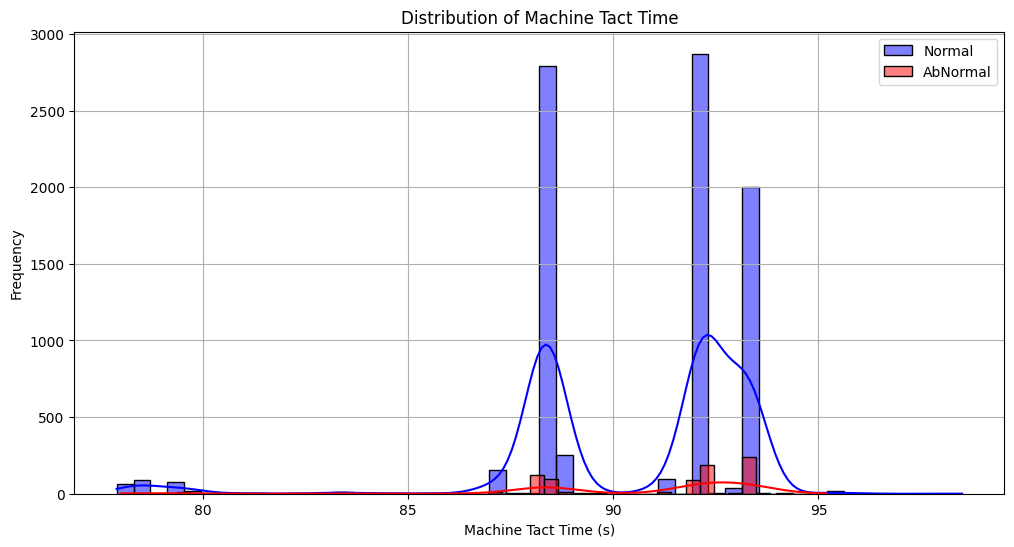

In [111]:
# Filter the data for abnormal and normal
abnormal_data2 = filtered_data2[filtered_data2['target'] == 'AbNormal']
normal_data2 = filtered_data2[filtered_data2['target'] == 'Normal']

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.histplot(normal_data2['Machine Tact time Collect Result_Dam'], bins=50, kde=True, color='blue', label='Normal')
sns.histplot(abnormal_data2['Machine Tact time Collect Result_Dam'], bins=50, kde=True, color='red', label='AbNormal')

plt.title('Distribution of Machine Tact Time')
plt.xlabel('Machine Tact Time (s)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [114]:
# Define the tact time ranges
tact_time_ranges = [(79.485, 81.069),(82.654, 84.238),(87.408, 88.992),(88.992, 90.577), (90.577, 92.162), (92.162, 93.746), (93.746, 95.331)]

# Initialize an empty dictionary to store the results
model_suffix_counts_by_range = {}

# Iterate over the defined tact time ranges
for start, end in tact_time_ranges:
    # Filter the data for the specified tact time range
    filtered_data = train_data[train_data['Machine Tact time Collect Result_Dam'].between(start, end)]
    
    # Get the unique model suffixes
    model_suffixes = filtered_data['Model.Suffix'].unique()
    
    # Initialize a dictionary to store counts for each model suffix
    model_suffix_counts = {}
    
    # Iterate over the unique model suffixes
    for model_suffix in model_suffixes:
        # Filter data for the current model suffix
        model_data = filtered_data[filtered_data['Model.Suffix'] == model_suffix]
        
        # Count the number of normal and abnormal rows
        normal_count = model_data[model_data['target'] == 'Normal'].shape[0]
        abnormal_count = model_data[model_data['target'] == 'AbNormal'].shape[0]
        
        # Store the counts in the dictionary
        model_suffix_counts[model_suffix] = {'Normal': normal_count, 'AbNormal': abnormal_count}
    
    # Store the result in the main dictionary
    model_suffix_counts_by_range[(start, end)] = model_suffix_counts

# Display the results
model_suffix_counts_by_range

{(79.485, 81.069): {'AJX75334502': {'Normal': 7, 'AbNormal': 2},
  'AJX75334505': {'Normal': 33, 'AbNormal': 2},
  'AJX75334501': {'Normal': 18, 'AbNormal': 2},
  'AJX75334507': {'Normal': 1, 'AbNormal': 0}},
 (82.654, 84.238): {'AJX75334501': {'Normal': 20, 'AbNormal': 8},
  'AJX75334502': {'Normal': 2, 'AbNormal': 0},
  'AJX75334505': {'Normal': 1, 'AbNormal': 0}},
 (87.408, 88.992): {'AJX75334501': {'Normal': 2885, 'AbNormal': 206},
  'AJX75334502': {'Normal': 136, 'AbNormal': 18},
  'AJX75334505': {'Normal': 1, 'AbNormal': 0}},
 (88.992, 90.577): {'AJX75334501': {'Normal': 32, 'AbNormal': 6},
  'AJX75334502': {'Normal': 2, 'AbNormal': 1}},
 (90.577, 92.162): {'AJX75334501': {'Normal': 877, 'AbNormal': 102}},
 (92.162, 93.746): {'AJX75334501': {'Normal': 4132, 'AbNormal': 431},
  'AJX75334503': {'Normal': 2, 'AbNormal': 0},
  'AJX75334505': {'Normal': 1, 'AbNormal': 0},
  'AJX75334502': {'Normal': 1, 'AbNormal': 0}},
 (93.746, 95.331): {'AJX75334501': {'Normal': 7, 'AbNormal': 1},
 

In [115]:
# Initialize an empty dictionary to store the results
model_suffix_counts_by_range = {}

# Iterate over the defined tact time ranges
for start, end in tact_time_ranges:
    # Filter the data for the specified tact time range
    filtered_data = train_data[train_data['Machine Tact time Collect Result_Dam'].between(start, end)]
    
    # Get the unique model suffixes
    model_suffixes = filtered_data['Workorder'].unique()
    
    # Initialize a dictionary to store counts for each model suffix
    model_suffix_counts = {}
    
    # Iterate over the unique model suffixes
    for model_suffix in model_suffixes:
        # Filter data for the current model suffix
        model_data = filtered_data[filtered_data['Workorder'] == model_suffix]
        
        # Count the number of normal and abnormal rows
        normal_count = model_data[model_data['target'] == 'Normal'].shape[0]
        abnormal_count = model_data[model_data['target'] == 'AbNormal'].shape[0]
        
        # Store the counts in the dictionary
        model_suffix_counts[model_suffix] = {'Normal': normal_count, 'AbNormal': abnormal_count}
    
    # Store the result in the main dictionary
    model_suffix_counts_by_range[(start, end)] = model_suffix_counts

# Display the results
model_suffix_counts_by_range

{(79.485, 81.069): {'4C1XH315-1': {'Normal': 5, 'AbNormal': 1},
  '4C1XH945-1': {'Normal': 2, 'AbNormal': 0},
  '4E1XA654-1': {'Normal': 1, 'AbNormal': 1},
  '4C1XJ039-1': {'Normal': 8, 'AbNormal': 1},
  '4C1XJ377-1': {'Normal': 3, 'AbNormal': 0},
  '4E1XA548-1': {'Normal': 3, 'AbNormal': 0},
  '4E1X9170-1': {'Normal': 4, 'AbNormal': 0},
  '4E1XA027-2': {'Normal': 1, 'AbNormal': 0},
  '4C1XG928-1': {'Normal': 11, 'AbNormal': 0},
  '4C1XH940-1': {'Normal': 1, 'AbNormal': 0},
  '4C1XG294-1': {'Normal': 1, 'AbNormal': 0},
  '4E1XA028-1': {'Normal': 2, 'AbNormal': 0},
  '4E1X9169-1': {'Normal': 1, 'AbNormal': 0},
  '4C1XH943-2': {'Normal': 1, 'AbNormal': 0},
  '4C1XD439-2': {'Normal': 2, 'AbNormal': 0},
  '4C1XJ038-1': {'Normal': 1, 'AbNormal': 0},
  '4C1XD029-2': {'Normal': 2, 'AbNormal': 0},
  '4E1X0057-1': {'Normal': 2, 'AbNormal': 0},
  '4E1X9996-1': {'Normal': 1, 'AbNormal': 0},
  '4C1XH941-1': {'Normal': 3, 'AbNormal': 1},
  '4E1XA548-2': {'Normal': 0, 'AbNormal': 2},
  '3K1X9887-1':

Mahcine Tact time Fill1, 2, Dam을 전부 다 더한 변수를 만들어보았다.

In [92]:
# Divide the machine tact time into 10 classes
time_bins = pd.cut(train_data['Total Machine Tact Time'], bins=8)

# Group by the time bins and target to find the count of abnormal and normal for each class
class_counts = train_data.groupby([time_bins, 'target']).size().unstack(fill_value=0)

# Calculate the abnormal composition ratio for each class
class_counts['Abnormal Composition Ratio'] = class_counts['AbNormal'] / (class_counts['AbNormal'] + class_counts['Normal'])

# Fill NaN values with 0 (in cases where both AbNormal and Normal counts are 0)

class_counts

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_3148\3033034205.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  class_counts = train_data.groupby([time_bins, 'target']).size().unstack(fill_value=0)


target,AbNormal,Normal,Abnormal Composition Ratio
Total Machine Tact Time,,,
"(76.074, 205.3]",2326,37888,0.057841
"(205.3, 333.5]",23,262,0.080702
"(333.5, 461.7]",0,5,0.000000
"(461.7, 589.9]",0,0,NaN
"(589.9, 718.1]",0,1,0.000000
"(718.1, 846.3]",0,0,NaN
"(846.3, 974.5]",0,0,NaN
"(974.5, 1102.7]",1,0,1.000000
